In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde  # For better time feature distribution matching
from torch.utils.tensorboard import SummaryWriter  # TensorBoard for loss tracking

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
df=pd.read_csv(r'glass.csv')


# Count the number of instances per class
class_counts = df['Type'].value_counts()
print("Class counts:")
print(class_counts)

# Get the number of unique classes
num_classes = df['Type'].nunique()
print("\nNumber of classes:", num_classes)

# Calculate the percentage of each class in the dataset
class_percentages = (class_counts / len(df)) * 100
print("\nClass percentages:")
print(class_percentages)

# Optional: Check for imbalance using a simple ratio between the minority and majority class
min_count = class_counts.min()
max_count = class_counts.max()
imbalance_ratio = min_count / max_count
print("\nImbalance ratio (min_count / max_count):", imbalance_ratio)

# Define a threshold to decide imbalance (for example, if the smallest class is less than 50% of the largest)
if imbalance_ratio < 0.5:
    print("\nThe dataset appears to be imbalanced.")
else:
    print("\nThe dataset appears to be balanced.")

Class counts:
Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

Number of classes: 6

Class percentages:
Type
2    35.514019
1    32.710280
7    13.551402
3     7.943925
5     6.074766
6     4.205607
Name: count, dtype: float64

Imbalance ratio (min_count / max_count): 0.11842105263157894

The dataset appears to be imbalanced.


In [4]:
class CRBM(nn.Module):
    def __init__(self, n_visible, n_hidden, n_conditions):
        super(CRBM, self).__init__()
        
        # Xavier initialization for stability
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * np.sqrt(2.0/(n_visible + n_hidden)))
        self.b = nn.Parameter(torch.zeros(n_visible))
        self.a = nn.Parameter(torch.zeros(n_hidden))
        self.U = nn.Parameter(torch.randn(n_conditions, n_hidden) * np.sqrt(2.0/(n_conditions + n_hidden)))
        
        self.batch_norm = nn.BatchNorm1d(n_hidden)  # Adding batch normalization

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_conditions = n_conditions
    
    def free_energy(self, v, c):
        """Compute the free energy with KL regularization"""
        vW = torch.matmul(v, self.W)
        cU = torch.matmul(c, self.U)
        hidden_activations = self.batch_norm(self.a + vW + cU)  # Apply batch norm
        hidden_term = F.softplus(hidden_activations).sum(dim=1)

        # KL divergence term to prevent mode collapse
        kl_term = 0.01 * torch.sum(self.W ** 2)
        
        return -torch.matmul(v, self.b) - hidden_term + kl_term
    
    def sample_h_given_v_c(self, v, c, temperature=1.0):
        """Sample hidden units with temperature scaling"""
        v, c = v.to(device), c.to(device)
        activation = (torch.matmul(v, self.W) + torch.matmul(c, self.U) + self.a) / temperature
        p_h = torch.sigmoid(activation)
        return p_h, torch.bernoulli(p_h)
    
    def sample_v_given_h(self, h):
        """Sample visible units given hidden units with clamping"""
        h = h.to(device)
        activation = torch.matmul(h, self.W.t()) + self.b
        p_v = torch.sigmoid(torch.clamp(activation, -80, 80))
        return p_v, torch.bernoulli(p_v)
    
    def gibbs_sampling(self, v, c, k=50):  # Increased k from 10 to 50
        """Perform k-step Gibbs sampling"""
        v, c = v.to(device), c.to(device)
        v_k = v
        for _ in range(k):
            p_h, h = self.sample_h_given_v_c(v_k, c)
            p_v, v_k = self.sample_v_given_h(h)
        return p_v, v_k, p_h, h
    
    def contrastive_divergence(self, v_pos, c, k=1):
        """Contrastive Divergence with k steps"""
        v_pos, c = v_pos.to(device), c.to(device)
        p_h_pos, h_pos = self.sample_h_given_v_c(v_pos, c)
        p_v_neg, v_neg, p_h_neg, h_neg = self.gibbs_sampling(v_pos, c, k)
        return p_h_pos, h_pos, p_v_neg, v_neg, p_h_neg, h_neg
    
    def forward(self, v, c):
        """Forward pass"""
        p_h, h = self.sample_h_given_v_c(v, c)
        return p_h, h

In [5]:
def load_glass_data(file_path):
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        print("Trying alternative path...")
        # Try alternative paths
        alternative_paths = ['glass.csv', '../glass.csv', './data/glass.csv']
        for path in alternative_paths:
            try:
                data = pd.read_csv(path)
                print(f"Successfully loaded from {path}")
                break
            except FileNotFoundError:
                continue
        else:
            raise FileNotFoundError(f"Could not find creditcard.csv in any of the expected locations")
    
    # Separate features and target
    X = data.drop('Type', axis=1)
    y = data['Type']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.values.reshape(-1, 1))
    
    return X_scaled, y, y_onehot, scaler, encoder

In [6]:
def train_crbm(model, X_train, y_onehot_train, batch_size=64, num_epochs=20, lr=0.01, k=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the correct device
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate decay
    
    # ✅ Move dataset to device before creating TensorDataset
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_onehot_train_tensor = torch.FloatTensor(y_onehot_train).to(device)

    dataset = TensorDataset(X_train_tensor, y_onehot_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, 
                            persistent_workers=True if batch_size > 1 else False)

    writer = SummaryWriter()  # TensorBoard logger
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (v, c) in enumerate(dataloader):
            v, c = v.to(device), c.to(device)  # ✅ Move batch to device
            
            # ✅ Ensure all operations happen on the same device
            p_h_pos, h_pos, p_v_neg, v_neg, p_h_neg, h_neg = model.contrastive_divergence(v, c, k)
            loss = torch.mean(model.free_energy(v, c) - model.free_energy(v_neg, c))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)
        writer.add_scalar("CRBM/Loss", avg_epoch_loss, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}')
        scheduler.step()

    writer.close()
    return losses

In [7]:
def generate_synthetic_samples(model, condition_vector, n_samples=100, gibbs_steps=50):
    v = torch.rand(n_samples, model.n_visible)
    c = condition_vector.repeat(n_samples, 1)
    
    for _ in range(gibbs_steps):
        p_h, h = model.sample_h_given_v_c(v, c, temperature=0.8)  # Use temperature scaling
        p_v, v = model.sample_v_given_h(h)
    
    return v.cpu().detach().numpy() 

In [8]:
def generate_realistic_time_distribution(original_df, synthetic_df):
    """Match time distribution using KDE"""
    fraud_times = original_df[original_df['Class'] == 1]['Time'].values
    kde = gaussian_kde(fraud_times)
    synthetic_times = kde.resample(len(synthetic_df)).flatten()
    
    synthetic_df['Time'] = np.clip(synthetic_times, original_df['Time'].min(), original_df['Time'].max())
    return synthetic_df

In [9]:
def visualize_results(original_df, balanced_df, feature_columns, target_col='Type', n_samples=1000):
    """
    Visualize the results of the synthetic data generation for multi-class.

    Parameters:
    - original_df: DataFrame with original imbalanced data
    - balanced_df: DataFrame with balanced data (original + synthetic)
    - feature_columns: List of feature column names
    - target_col: The name of the target column (e.g., 'Type')
    - n_samples: Number of samples to use for visualization
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import pandas as pd
    import numpy as np

    plt.figure(figsize=(16, 12))

    # 1. Class Distribution Before and After
    plt.subplot(2, 2, 1)
    original_counts = original_df[target_col].value_counts().sort_index()
    balanced_counts = balanced_df[target_col].value_counts().sort_index()

    class_dist_df = pd.DataFrame({
        'Original': original_counts,
        'Balanced': balanced_counts
    })

    class_dist_df.plot(kind='bar', ax=plt.gca())
    plt.title('Class Distribution Before and After Balancing')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.xticks(rotation=0)

    # 2. KDE Comparison of Top Features
    plt.subplot(2, 2, 2)
    top_features = feature_columns[:3]
    class_labels = sorted(original_df[target_col].unique())

    for feature in top_features:
        for label in class_labels:
            sns.kdeplot(original_df[original_df[target_col] == label][feature], label=f'Orig Class {label}')
            sns.kdeplot(balanced_df[balanced_df[target_col] == label][feature], label=f'Synth Class {label}', linestyle='--')
        break  # show only first feature for clarity
    plt.title('Feature KDE: Real vs Synthetic per Class')
    plt.xlabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 3. t-SNE Visualization
    plt.subplot(2, 2, 3)
    sample_orig = original_df.sample(min(n_samples, len(original_df)), random_state=42)
    sample_synth = balanced_df[len(original_df):].sample(min(n_samples, len(balanced_df) - len(original_df)), random_state=42)

    viz_data = pd.concat([sample_orig[feature_columns], sample_synth[feature_columns]])
    labels = pd.concat([sample_orig[target_col], sample_synth[target_col]])

    # Handle PCA dimension safely
    n_components = min(10, len(feature_columns), len(viz_data))
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(viz_data)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(pca_data)

    for label in sorted(labels.unique()):
        idx = labels == label
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {label}', alpha=0.6)
    plt.title('t-SNE: Real & Synthetic Class Distributions')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()

    # 4. Correlation Matrix Difference
    plt.subplot(2, 2, 4)
    orig_corr = original_df[feature_columns].corr()
    bal_corr = balanced_df[feature_columns].corr()
    corr_diff = bal_corr - orig_corr

    sns.heatmap(corr_diff, cmap='coolwarm', center=0, annot=False, fmt=".2f",
                cbar_kws={'label': 'Correlation Difference'})
    plt.title('Feature Correlation Change\n(Balanced - Original)')

    plt.tight_layout()
    plt.show()


Epoch 1/50, Loss: -0.0005
Epoch 2/50, Loss: -0.0018
Epoch 3/50, Loss: -0.0030
Epoch 4/50, Loss: -0.0043
Epoch 5/50, Loss: -0.0057
Epoch 6/50, Loss: -0.0070
Epoch 7/50, Loss: -0.0071
Epoch 8/50, Loss: -0.0082
Epoch 9/50, Loss: -0.0092
Epoch 10/50, Loss: -0.0098
Epoch 11/50, Loss: -0.0104
Epoch 12/50, Loss: -0.0101
Epoch 13/50, Loss: -0.0112
Epoch 14/50, Loss: -0.0110
Epoch 15/50, Loss: -0.0113
Epoch 16/50, Loss: -0.0115
Epoch 17/50, Loss: -0.0122
Epoch 18/50, Loss: -0.0119
Epoch 19/50, Loss: -0.0123
Epoch 20/50, Loss: -0.0126
Epoch 21/50, Loss: -0.0122
Epoch 22/50, Loss: -0.0123
Epoch 23/50, Loss: -0.0128
Epoch 24/50, Loss: -0.0129
Epoch 25/50, Loss: -0.0127
Epoch 26/50, Loss: -0.0129
Epoch 27/50, Loss: -0.0128
Epoch 28/50, Loss: -0.0138
Epoch 29/50, Loss: -0.0130
Epoch 30/50, Loss: -0.0133
Epoch 31/50, Loss: -0.0139
Epoch 32/50, Loss: -0.0131
Epoch 33/50, Loss: -0.0130
Epoch 34/50, Loss: -0.0130
Epoch 35/50, Loss: -0.0135
Epoch 36/50, Loss: -0.0135
Epoch 37/50, Loss: -0.0135
Epoch 38/5

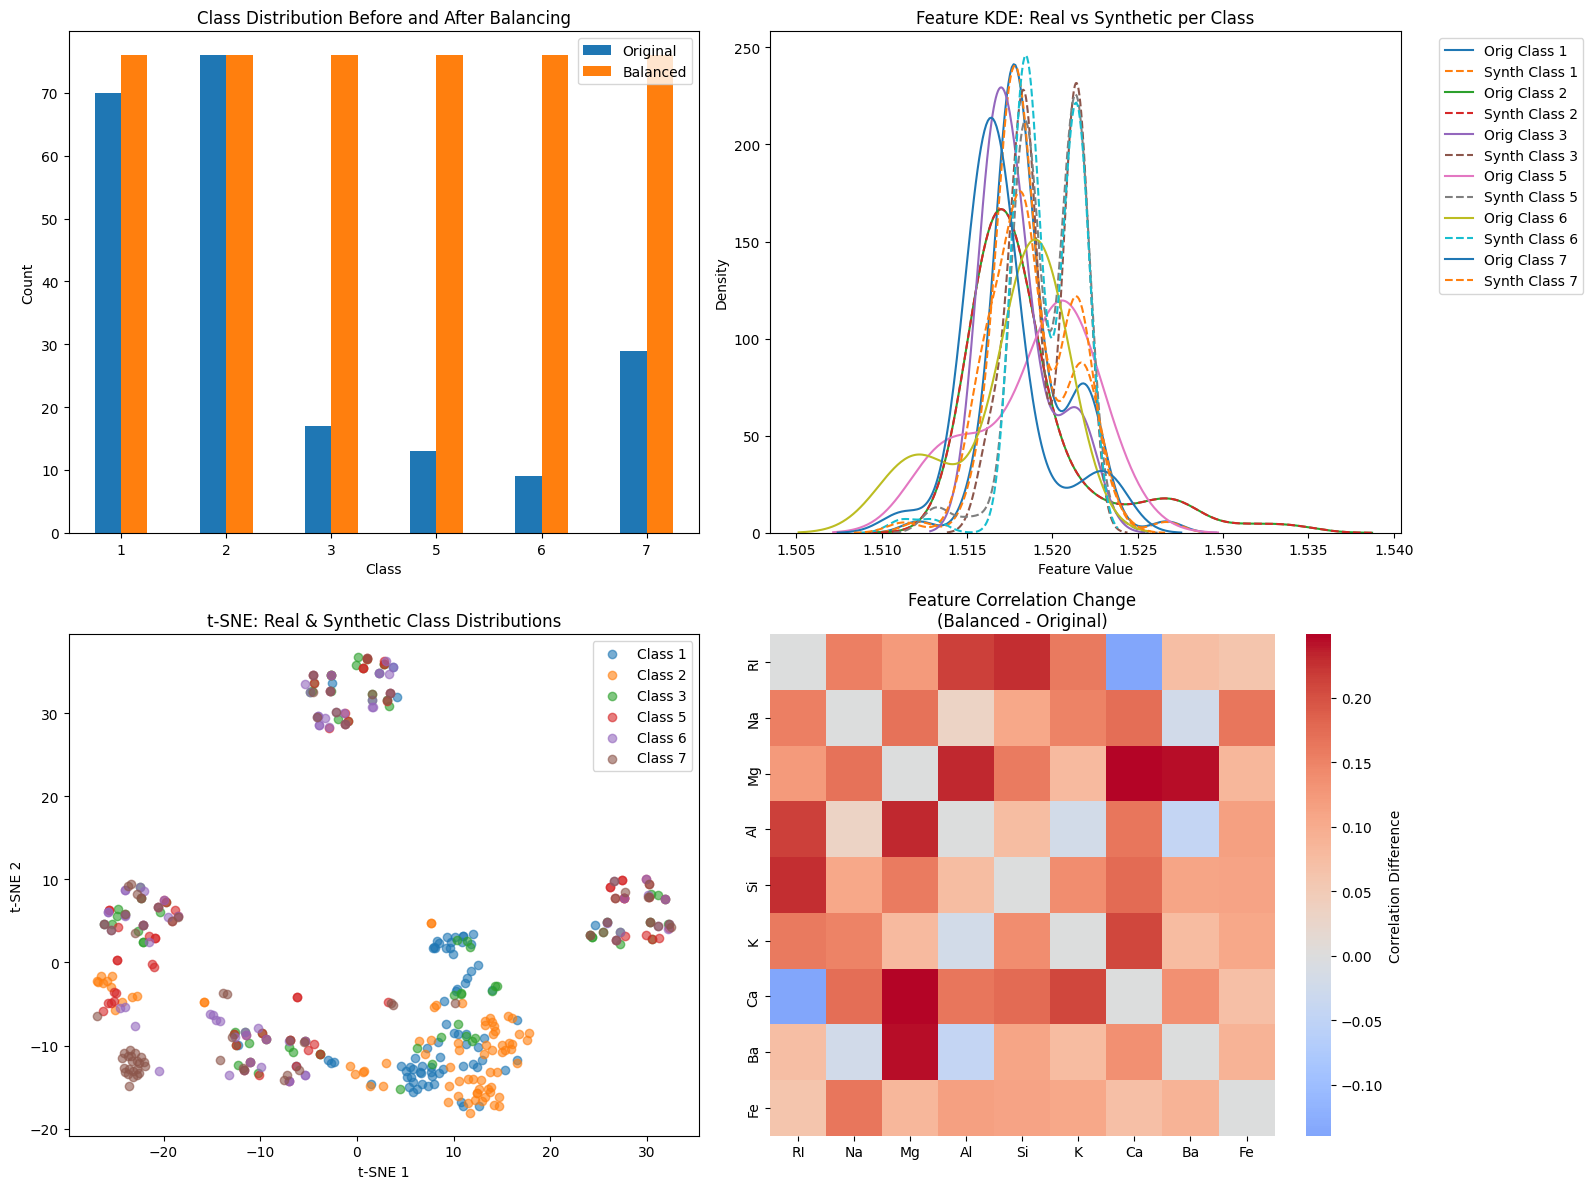

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Assume CRBM, train_crbm, generate_synthetic_samples, and visualize_results are defined above ---
# (No changes to the CRBM implementation)

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Load glass dataset
    data = pd.read_csv('glass.csv')
    feature_columns = data.drop('Type', axis=1).columns.tolist()

    # Separate features and target
    X = data.drop('Type', axis=1).values
    y = data['Type'].values

    # Scale features and one-hot encode target
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))

    # Stratified split for training the CRBM
    X_train, _, y_train, _, y_onehot_train, _ = train_test_split(
        X_scaled, y, y_onehot, test_size=0.2, stratify=y, random_state=42
    )

    # Initialize and train CRBM (core implementation remains unchanged)
    crbm = CRBM(X_train.shape[1], 64, y_onehot_train.shape[1])
    train_crbm(crbm, X_train, y_onehot_train, num_epochs=50, lr=0.0001, k=1)

    # Balance all classes by generating synthetic samples for underrepresented ones
    class_counts = pd.Series(y).value_counts()
    max_count = class_counts.max()
    synthetic_dfs = []
    for class_id in sorted(class_counts.index):
        current_count = class_counts[class_id]
        n_to_generate = max_count - current_count
        if n_to_generate > 0:
            # Use the one-hot encoded condition for the specific class
            condition_vector = torch.FloatTensor(encoder.transform([[class_id]]))
            synthetic_samples = generate_synthetic_samples(crbm, condition_vector, n_samples=n_to_generate, gibbs_steps=50)
            synthetic_df = pd.DataFrame(scaler.inverse_transform(synthetic_samples), columns=feature_columns)
            synthetic_df['Type'] = class_id
            synthetic_dfs.append(synthetic_df)

    # Combine original data with synthetic data
    if synthetic_dfs:
        synthetic_data = pd.concat(synthetic_dfs, ignore_index=True)
        balanced_df = pd.concat([data, synthetic_data], ignore_index=True)
    else:
        balanced_df = data.copy()

    # Save the balanced dataset
    balanced_df.to_csv('balanced_glass.csv', index=False)
    print("✅ Balanced dataset saved as 'balanced_glass.csv'")

    # Show before vs. after class distribution
    print("\nClass distribution before balancing:")
    print(class_counts)
    print("\nClass distribution after balancing:")
    print(balanced_df['Type'].value_counts())

    # Visualize the results (this function remains unchanged)
    visualize_results(data, balanced_df, feature_columns, target_col='Type')

if __name__ == "__main__":
    main()


In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # raw logits; softmax is applied in loss/eval


In [13]:
df1=pd.read_csv('balanced_glass.csv')
df=pd.read_csv('glass.csv')


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [15]:
def preprocess_data(df, target_col='Type'):
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values

    # Map labels to 0-based classes
    label_map = {label: idx for idx, label in enumerate(np.unique(y))}
    y = np.array([label_map[val] for val in y])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    return train_loader, X_test_tensor, y_test_tensor


In [16]:
import torch.optim as optim

def train_model(model, train_loader, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_values = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)  # shape: (batch, num_classes)
            loss = criterion(outputs, y_batch)  # y_batch: LongTensor
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_values.append(total_loss / len(train_loader))
    return loss_values


In [17]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch.nn.functional as F

def evaluate_model(model, X_test, y_test, name="Model"):
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()

    print(f"\n--- {name} ---")
    print(classification_report(y_true, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_true, preds))

    # Compute macro/micro F1-scores
    f1_macro = f1_score(y_true, preds, average='macro')
    f1_micro = f1_score(y_true, preds, average='micro')
    print(f"F1 Macro: {f1_macro:.4f}, F1 Micro: {f1_micro:.4f}")

    # Binarize for ROC and PR plotting
    classes = sorted(np.unique(y_true))
    y_bin = label_binarize(y_true, classes=classes)

    # === ROC Curves ===
    plt.figure(figsize=(10, 5))
    for i, class_id in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_id} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curves (OvR)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # === Precision-Recall Curves ===
    plt.figure(figsize=(10, 5))
    for i, class_id in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], probs[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {class_id} (AUC = {pr_auc:.2f})')

    plt.title(f'{name} - Precision-Recall Curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()
        # === Macro-Averaged ROC Curve ===
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Interpolate and average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='navy', label=f'Macro-Average (AUC = {macro_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - Macro-Averaged ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # === Macro-Averaged PR Curve ===
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    all_recalls = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)
    macro_pr_auc = auc(all_recalls, mean_precision)

    plt.figure()
    plt.plot(all_recalls, mean_precision, color='darkorange', label=f'Macro-Average (AUC = {macro_pr_auc:.2f})')
    plt.title(f'{name} - Macro-Averaged PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()



In [18]:
print("Unique labels:", np.unique(df['Type']))

Unique labels: [1 2 3 5 6 7]



--- Balanced Model ---
              precision    recall  f1-score   support

           0       0.50      0.79      0.61        14
           1       0.43      0.20      0.27        15
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.60      1.00      0.75         6

    accuracy                           0.47        43
   macro avg       0.25      0.33      0.27        43
weighted avg       0.40      0.47      0.40        43

Confusion Matrix:
 [[11  2  1  0  0  0]
 [ 8  3  0  1  1  2]
 [ 3  0  0  0  0  0]
 [ 0  2  0  0  1  0]
 [ 0  0  0  0  0  2]
 [ 0  0  0  0  0  6]]
F1 Macro: 0.2723, F1 Micro: 0.4651


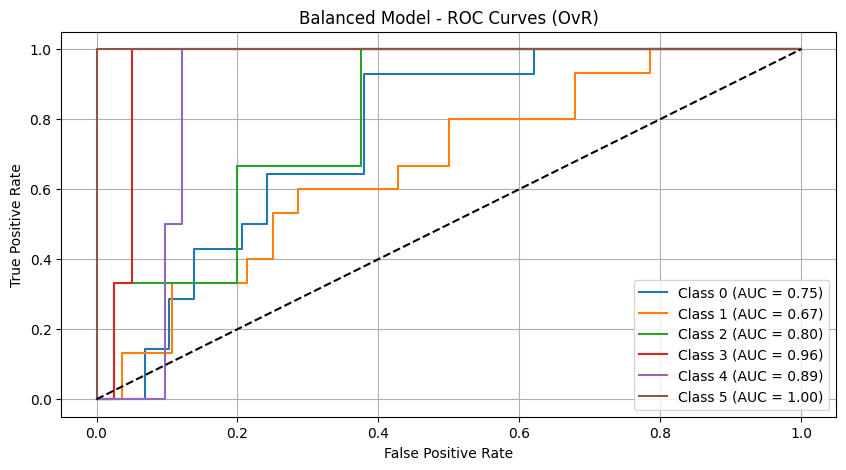

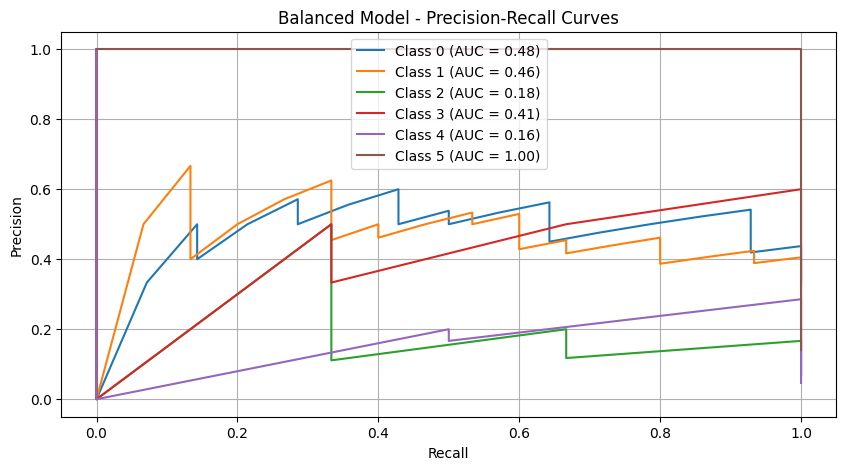

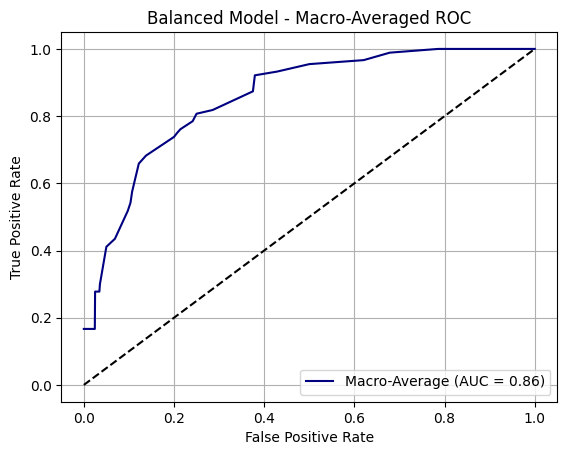

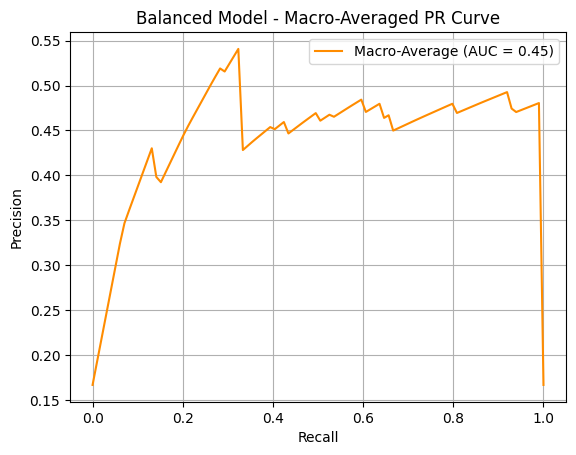


--- Original Model ---
              precision    recall  f1-score   support

           0       0.50      0.87      0.63        15
           1       0.62      0.53      0.57        15
           2       0.13      0.20      0.16        15
           3       0.00      0.00      0.00        16
           4       0.41      0.44      0.42        16
           5       0.40      0.27      0.32        15

    accuracy                           0.38        92
   macro avg       0.34      0.38      0.35        92
weighted avg       0.34      0.38      0.35        92

Confusion Matrix:
 [[13  1  0  0  0  1]
 [ 7  8  0  0  0  0]
 [ 5  2  3  2  2  1]
 [ 0  1  6  0  6  3]
 [ 0  1  6  1  7  1]
 [ 1  0  8  0  2  4]]
F1 Macro: 0.3513, F1 Micro: 0.3804


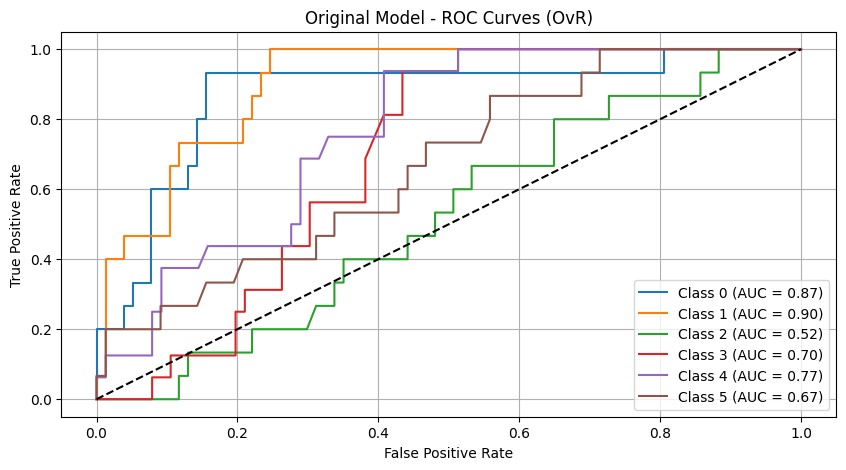

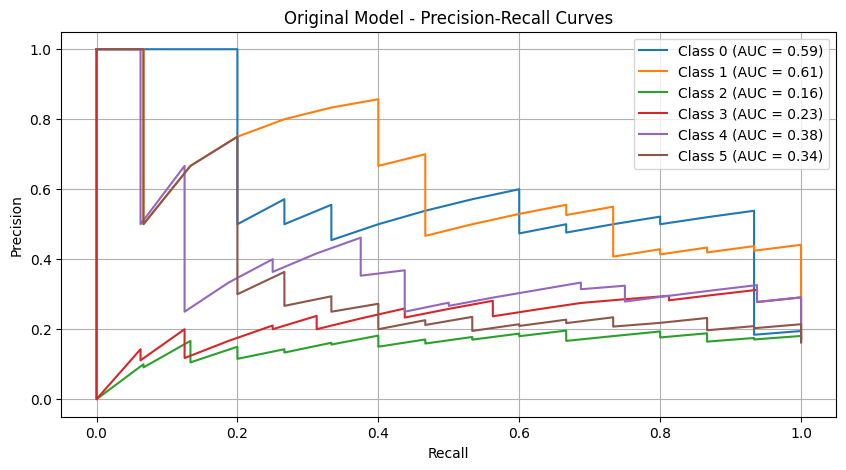

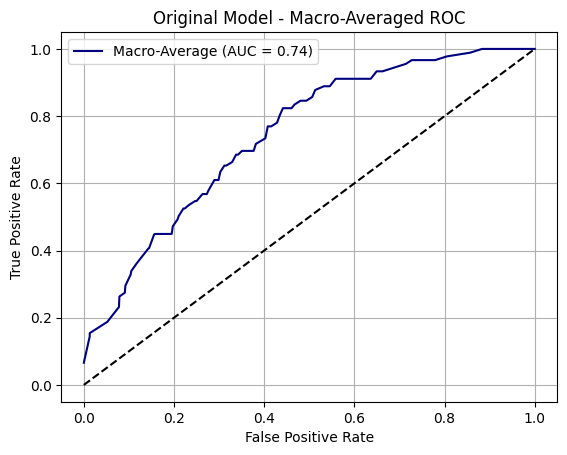

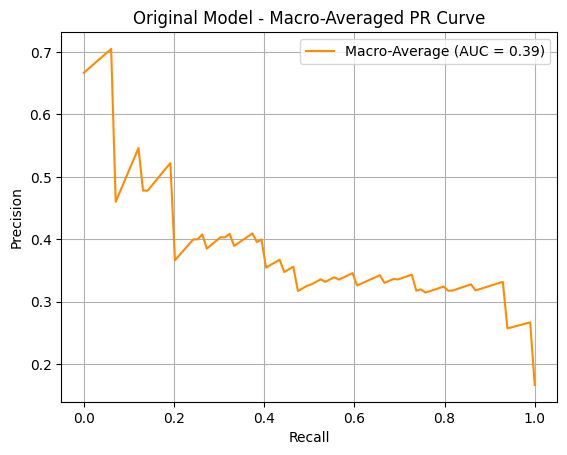

In [19]:
# Preprocess original and balanced datasets
train1, X_test1, y_test1 = preprocess_data(df)
train2, X_test2, y_test2 = preprocess_data(df1)

# Set input and output dimensions
input_dim = df1.shape[1] - 1
num_classes = len(np.unique(df1['Type']))

# Initialize models
model1 = LogisticRegressionModel(input_dim, num_classes).to(device)
model2 = LogisticRegressionModel(input_dim, num_classes).to(device)

# Train models
loss1 = train_model(model1, train1)
loss2 = train_model(model2, train2)

# Evaluate models
evaluate_model(model1, X_test1, y_test1, "Balanced Model")
evaluate_model(model2, X_test2, y_test2, "Original Model")
